In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("project3.ipynb")

# Project 3: Movie Classification

Welcome to the third project of Data 8! You will build a classification model that guesses whether a movie is a comedy or a thriller by using only the number of times chosen words appear in the movie's screenplay. By the end of the project, you should know how to:

1. Build a k-nearest-neighbors classifier.
2. Test a classifier on data.

### Logistics

**Deadline.**  This project is due at **11:59pm PT on Friday, 04/29**. You can receive 5 bonus points for submitting the project by **11:59pm PT on Thursday, 04/28.** Projects will be accepted up to 2 days (48 hours) late. Projects submitted fewer than 24 hours after the deadline will receive 2/3 credit, and projects submitted between 24 and 48 hours after the deadline will receive 1/3 credit. We will *not accept* any projects that are submitted 48 hours or more after the deadline. **There will be no lenience with late submissions.** That includes if you miss the deadline due to internet or submission issues. Please submit early if you anticipate this being a problem. It's **much** better to be early than late, so start working now.

**Checkpoint.**  For full credit, you must complete a checkpoint. For the checkpoint, you must complete the questions up until **the end of Part 2**, pass all public autograder tests for those sections, and submit to the Gradescope Project 3 Checkpoint assignment by **11:59pm PT on Friday, 04/22**. This checkpoint is worth 5% of your entire project grade. There is **no partial credit** for the checkpoint, and we **do not accept late checkpoint submissions**. After you've submitted the checkpoint, you may still change your answers before the project deadline -- only your final submission, to the Project 3 assignment, will be graded for correctness. You will have some lab time to work on these questions, but we recommend that you start the project before lab and leave time to finish the checkpoints afterward.

**Partners.** You may work with one other partner; your partner must be from your assigned lab section. **Only one person is required to submit to the checkpoint and project assignments. On Gradescope, the person who submits *must* also designate their partner so that both of you receive credit.** Once you submit, click into your submission, and there will be an option to Add Group Member in the top right corner. You may also reference [this walkthrough video](https://drive.google.com/file/d/1POtij6KECSBjCUeOC_F0Lt3ZmKN7LKIq/view?usp=sharing) on how to add partners on Gradescope. Make sure to **re-add your partner every time you make a new submission**, as Gradescope does not save partner information.

**Rules.** Don't share your code with anybody but your partner. You are welcome to discuss questions with other students, but don't share the answers. The experience of solving the problems in this project will prepare you for exams (and life). If someone asks you for the answer, resist! Instead, you can demonstrate how you would solve a similar problem.

**Support.** You are not alone! Come to office hours, post on Ed, and talk to your classmates. If you want to ask about the details of your solution to a problem, make a private Ed post and the staff will respond. If you're ever feeling overwhelmed or don't know how to make progress, email your TA or tutor for help. You can find contact information for the staff on the [course website](http://data8.org/sp22/staff.html).

**Tests.** The tests that are given are **not comprehensive** and passing the tests for a question **does not** mean that you answered the question correctly. Tests usually only check that your table has the correct column labels. However, more tests will be applied to verify the correctness of your submission in order to assign your final score, so be careful and check your work! You might want to create your own checks along the way to see if your answers make sense. Additionally, before you submit, make sure that none of your cells take a very long time to run (several minutes).

**Free Response Questions.** Make sure that you put the answers to the written questions in the indicated cell we provide. **Every free response question should include an explanation** that adequately answers the question. Your written work will be uploaded to Gradescope automatically after the project deadline; there is no action required on your part for this. 

**Advice.** Develop your answers incrementally. To perform a complicated task, break it up into steps, perform each step on a different line, give a new name to each result, and check that each intermediate result is what you expect. You can add any additional names or functions you want to the provided cells. Make sure that you are using distinct and meaningful variable names throughout the notebook. Along that line, **DO NOT** reuse the variable names that we use when we grade your answers. 

You **never** have to use just one line in this project or any others. Use intermediate variables and multiple lines as much as you would like!

All of the concepts necessary for this project are found in the textbook. If you are stuck on a particular problem, reading through the relevant textbook section often will help clarify the concept.


---

To get started, load `datascience`, `numpy`, `plots`, and `d8error`. Make sure to also run the first cell of this notebook to load `otter`.

In [2]:
# Run this cell to set up the notebook, but please don't change it.
import numpy as np
import math
import datascience
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter("ignore")

import d8error

# Part 1: The Dataset

In this project, we are exploring movie screenplays. We'll be trying to predict each movie's genre from the text of its screenplay. In particular, we have compiled a list of 5,000 words that occur in conversations between movie characters. For each movie, our dataset tells us the frequency with which each of these words occurs in certain conversations in its screenplay. All words have been converted to lowercase.

Run the cell below to read the `movies` table. **It may take up to a minute to load.**

In [3]:
movies = Table.read_table('movies.csv')

Here is one row of the table and some of the frequencies of words that were said in the movie.

In [4]:
movies.where("Title", "runaway bride").select(0, 1, 2, 3, 4, 14, 49, 1042, 4004)

Title,Year,Rating,Genre,# Words,breez,england,it,bravo
runaway bride,1999,5.2,comedy,4895,0,0,0.0234092,0


The above cell prints a few columns of the row for the comedy movie *Runaway Bride*.  The movie contains 4895 words. The word "it" appears 115 times, as it makes up  $\frac{115}{4895} \approx 0.0234092$ of the words in the movie. The word "england" doesn't appear at all.

Additional context: This numerical representation of a body of text, one that describes only the frequencies of individual words, is called a bag-of-words representation. This is a model that is often used in [NLP](https://en.wikipedia.org/wiki/Natural_language_processing). A lot of information is discarded in this representation: the order of the words, the context of each word, who said what, the cast of characters and actors, etc. However, a bag-of-words representation is often used for machine learning applications as a reasonable starting point, because a great deal of information is also retained and expressed in a convenient and compact format. 

In this project, we will investigate whether this representation is sufficient to build an accurate genre classifier.

All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

*Note: All movies in our dataset have their titles lower-cased.* 

In [5]:
title_index = movies.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

row_for_title('toy story')

Row(Title='toy story', Year='1995', Rating=8.2, Genre='comedy', # Words=3016, she=0.0017427675148135, decid=0.0003485535029627, talk=0.0017427675148135, wit=0.0, razor=0.0, slam=0.0, credit=0.0, rai=0.0, hugh=0.0, breez=0.0, conscienc=0.0, audienc=0.0, cathi=0.0, log=0.0, met=0.0, chosen=0.0, grip=0.0, booz=0.0, bianca=0.0, doubl=0.0003485535029627, agent=0.0, exit=0.0, carpent=0.0, underground=0.0, clemenza=0.0, gain=0.0, neg=0.0006971070059254, majesti=0.0, studio=0.0, chri=0.0, spin=0.0, greater=0.0, eaten=0.0, vibrat=0.0, stupid=0.0010456605088881, cigarett=0.0, jesu=0.0, mani=0.0, violin=0.0, financi=0.0003485535029627, bai=0.0, cop=0.0, neighbor=0.0, cd=0.0, england=0.0, made=0.0003485535029627, conni=0.0, instinct=0.0, took=0.0, jacquelin=0.0, mace=0.0, disappear=0.0, waltz=0.0, behind=0.0003485535029627, bourbon=0.0, favorit=0.0006971070059254, benni=0.0, manhattan=0.0, nixon=0.0, lunch=0.0, principl=0.0, tradit=0.0, counterfeit=0.0, sophi=0.0, third=0.0, exist=0.0, wouldv=0.00

For example, the fastest way to find the frequency of "fun" in the movie *Toy Story* is to access the `'fun'` item from its row. Check the original table to see if this worked for you!

In [6]:
row_for_title('toy story').item('fun') 

0.0003485535029627

#### Question 1.0
Set `expected_row_sum` to the number that you __expect__ will result from summing all proportions in each row, excluding the first five columns. Think about what any one row adds up to.

<!--
BEGIN QUESTION
name: q1_0
points:
 - 0
 - 3
-->

In [7]:
# Set row_sum to a number that's the (approximate) sum of each row of word proportions.
expected_row_sum = 1

In [8]:
grader.check("q1_0")

q1_0 results: All test cases passed!

This dataset was extracted from [a dataset from Cornell University](http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). After transforming the dataset (e.g., converting the words to lowercase, removing the naughty words, and converting the counts to frequencies), we created this new dataset containing the frequency of 5000 common words in each movie.

In [9]:
print('Words with frequencies:', movies.drop(np.arange(5)).num_columns) 
print('Movies with genres:', movies.num_rows)

Words with frequencies: 5000
Movies with genres: 333


## 1.1. Word Stemming
The columns other than "Title", "Year", "Rating", "Genre", and "# Words" in the `movies` table are all words that appear in some of the movies in our dataset.  These words have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each movie. This is a common technique used in machine learning and natural language processing.

Stemming makes it a little tricky to search for the words you want to use, so we have provided another table called `vocab_table` that will let you see examples of unstemmed versions of each stemmed word. Run the code below to load it.

**Note:** You should use `vocab_table` for the rest of Section 1.1, not `vocab_mapping`. 

In [10]:
# Just run this cell.
vocab_mapping = Table.read_table('stem.csv')
stemmed = np.take(movies.labels, np.arange(3, len(movies.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(1100, 1110))

Stem,Word
bond,bonding
bone,bone
bone,boning
bone,bones
bonu,bonus
book,bookings
book,books
book,booking
book,booked
book,book


#### Question 1.1.1
Using `vocab_table`, find the stemmed version of the word "elements" and assign the value to `stemmed_message`.

<!--
BEGIN QUESTION
name: q1_1_1
points:
 - 0
 - 0
 - 3
-->

In [11]:
stemmed_message = vocab_table.where('Word', are.equal_to('elements')).column(0).item(0)
stemmed_message

'element'

In [12]:
grader.check("q1_1_1")

q1_1_1 results: All test cases passed!

#### Question 1.1.2
What stem in the dataset has the most words that are shortened to it? Assign `most_stem` to that stem. 

<!--
BEGIN QUESTION
name: q1_1_2
points:
 - 0
 - 3
-->

In [13]:
most_stem = vocab_table.group('Stem').sort('count', descending = True).column(0).item(0)
most_stem

'gener'

In [14]:
grader.check("q1_1_2")

q1_1_2 results: All test cases passed!

#### Question 1.1.3
What is the longest word in the dataset whose stem wasn't shortened? Assign that to `longest_uncut`. Break ties alphabetically from Z to A (so if your options are "cat" or "bat", you should pick "cat"). Note that when sorting letters, the letter `a` is smaller than the letter `z`.

*Hint 1:* `vocab_table` has 2 columns: one for stems and one for the unstemmed (normal) word. Find the longest word that wasn't cut at all (same length as stem).

*Hint 2:* There is a table function that allows you to compute a function on every element in a column. Check [Python Reference](http://data8.org/sp22/python-reference.html) if you aren't sure which one.

*Hint 3:* Check the comments in the cell below if you are stuck.

<!--
BEGIN QUESTION
name: q1_1_3
points:
 - 0
 - 3
-->

In [15]:
# In our solution, we found it useful to first add columns with
# the length of the word and the length of the stem,
# and then to add a column with the difference between those lengths.
# What will the difference be if the word is not shortened?

tbl_with_lens = vocab_table.with_columns("Stem Length", vocab_table.apply(len, 'Stem'), "Word Length", vocab_table.apply(len, 'Word'))
tbl_with_diff = tbl_with_lens.with_columns('Difference', tbl_with_lens.column('Word Length') - tbl_with_lens.column('Stem Length'))

longest_uncut = tbl_with_diff.where('Difference', are.equal_to(0)).sort('Word Length', descending = True).column(1).item(1)
longest_uncut

'misunderstand'

In [16]:
tbl_with_diff.where('Difference', are.equal_to(0)).sort('Word Length', descending = True)

Stem,Word,Stem Length,Word Length,Difference
extraordinari,extraordinary,13,13,0
misunderstand,misunderstand,13,13,0
frankenstein,frankenstein,12,12,0
neighborhood,neighborhood,12,12,0
particularli,particularly,12,12,0
philadelphia,philadelphia,12,12,0
psychiatrist,psychiatrist,12,12,0
psychologist,psychologist,12,12,0
relationship,relationship,12,12,0
anniversari,anniversary,11,11,0


In [17]:
grader.check("q1_1_3")

q1_1_3 results: All test cases passed!

#### Question 1.1.4
How many stems have only one word that is shortened to them? For example, if the stem "book" only maps to the word "books" and if the stem "a" only maps to the word "a," both should be counted as stems that map only to a single word.

Assign `count_single_stems` to the count of stems that map to one word only. 

<!--
BEGIN QUESTION
name: q1_1_4
points:
 - 0
 - 3
-->

In [18]:
count_single_stems = vocab_table.group('Stem').where('count', are.equal_to(1)).num_rows
count_single_stems

1408

In [19]:
grader.check("q1_1_4")

q1_1_4 results: All test cases passed!

## 1.2. Exploratory Data Analysis: Linear Regression

Let's explore our dataset before trying to build a classifier. To start, we’ll use the associated proportions to investigate the relationship between different words.

The first association we'll investigate is the association between the proportion of words that are "outer" and the proportion of words that are "space". 

As usual, we'll investigate our data visually before performing any numerical analysis.

Run the cell below to plot a scatter diagram of "space" proportions vs "outer" proportions and to create the `outer_space` table. Each point on the scatter plot represents one movie.

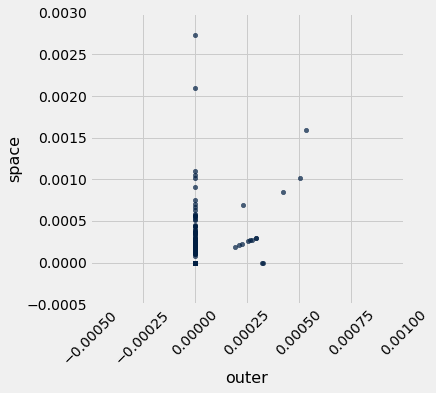

In [20]:
# Just run this cell!
outer_space = movies.select("outer", "space")
outer_space.scatter("outer", "space")
plots.axis([-0.0005, 0.001, -0.0005, 0.003]);
plots.xticks(rotation=45);

#### Question 1.2.1
Looking at that chart it is difficult to see if there is an association. Calculate the correlation coefficient for the potential linear association between proportion of words that are "outer" and the proportion of words that are "space" for every movie in the dataset, and assign it to `outer_space_r`. 

*Hint:* If you need a refresher on how to calculate the correlation coefficient check out [Ch 15.1](https://inferentialthinking.com/chapters/15/1/Correlation.html#calculating-r).
<!--
BEGIN QUESTION
name: q1_2_1
points:
 - 0
 - 3
-->

In [21]:
# These two arrays should make your code cleaner!
outer = movies.column("outer")
space = movies.column("space")

outer_su = (outer - np.mean(outer))/np.std(outer)  
space_su = (space - np.mean(space))/np.std(space)  

outer_space_r = np.mean(outer_su * space_su)
outer_space_r

0.3194260787689591

In [22]:
grader.check("q1_2_1")

q1_2_1 results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Question 1.2.2
Choose two *different* words in the dataset with a magnitude (absolute value) of correlation higher than 0.2 and plot a scatter plot with a line of best fit for them. Please do not pick "outer" and "space" or "san" and "francisco". The code to plot the scatter plot and line of best fit is given for you, you just need to calculate the correct values to `r`, `slope` and `intercept`. 

*Hint 1:* It's easier to think of words with a positive correlation, i.e. words that are often mentioned together*. Try to think of common phrases or idioms.

*Hint 2:* Refer to [Section 15.2](https://inferentialthinking.com/chapters/15/2/Regression_Line.html#units-of-measurement-of-the-slope) of the textbook for the formulas. 

<!--
BEGIN QUESTION
name: q1_2_2
manual: true
-->

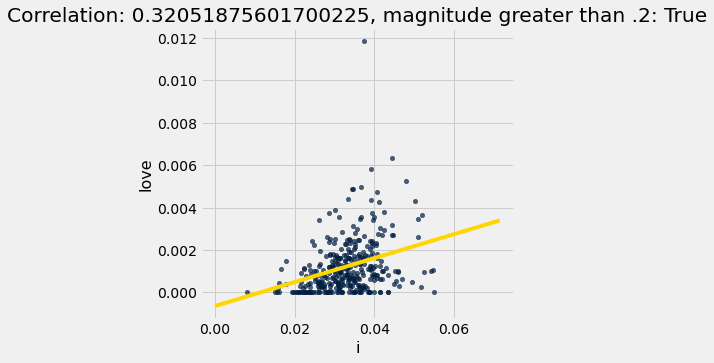

In [23]:
word_x = 'i'
word_y = 'love'

# These arrays should make your code cleaner!
arr_x = movies.column(word_x)
arr_y = movies.column(word_y)

x_su = (arr_x - np.mean(arr_x))/np.std(arr_x)
y_su = (arr_y - np.mean(arr_y))/np.std(arr_y)

r = np.mean(x_su * y_su)

slope = r * (np.std(arr_y)/np.std(arr_x))
intercept = np.mean(np.average(arr_y) - slope * np.average(arr_x))

# DON'T CHANGE THESE LINES OF CODE
movies.scatter(word_x, word_y)
max_x = max(movies.column(word_x))
plots.title(f"Correlation: {r}, magnitude greater than .2: {abs(r) >= 0.2}")
plots.plot([0, max_x * 1.3], [intercept, intercept + slope * (max_x*1.3)], color='gold');

<!-- END QUESTION -->

#### Question 1.2.3
Imagine that you picked the words "san" and "francisco" as the two words that you would expect to be correlated because they compose the city name San Francisco. Assign `san_francisco` to either the number 1 or the number 2 according to which statement is true regarding the correlation between "san" and "francisco." 

1. "san" can also preceed other city names like San Diego and San Jose. This might lead to "san" appearing in movies without "francisco," and would reduce the correlation between "san" and "francisco."
2. "san" can also preceed other city names like San Diego and San Jose. The fact that "san" could appear more often in front of different cities and without "francisco" would increase the correlation between "san" and "francisco." 

<!--
BEGIN QUESTION
name: q1_2_3
points:
 - 0
 - 3
-->

In [24]:
san_francisco = 1

In [25]:
grader.check("q1_2_3")

q1_2_3 results: All test cases passed!

## 1.3. Splitting the dataset
Now, we're going to use our `movies` dataset for two purposes.

1. First, we want to *train* movie genre classifiers.
2. Second, we want to *test* the performance of our classifiers. 

Hence, we need two different datasets: *training* and *test*. 

The purpose of a classifier is to classify unseen data that is similar to the training data. The test dataset will help us determine the accuracy of our predictions by comparing the actual genres of the movies with the genres that our classifier predicts. Therefore, we must ensure that there are no movies that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the first 85% of the dataset for training and the rest for test. 

Run the code below (without changing it) to separate the datasets into two tables.

In [26]:
# Here we have defined the proportion of our data
# that we want to designate for training as 17/20ths
# of our total dataset.  3/20ths of the data is
# reserved for testing.

training_proportion = 17/20

num_movies = movies.num_rows
num_train = int(num_movies * training_proportion)
num_test = num_movies - num_train

train_movies = movies.take(np.arange(num_train))
test_movies = movies.take(np.arange(num_train, num_movies))

print("Training: ",   train_movies.num_rows, ";",
      "Test: ",       test_movies.num_rows)

Training:  283 ; Test:  50


<!-- BEGIN QUESTION -->

#### Question 1.3.1
Draw a horizontal bar chart with two bars that show the proportion of Comedy movies in each dataset (`train_movies` and `test_movies`). The two bars should be labeled "Training" and "Test". Complete the function `comedy_proportion` first; it should help you create the bar chart. 

*Hint*: Refer to [Section 7.1](https://inferentialthinking.com/chapters/07/1/Visualizing_Categorical_Distributions.html#bar-chart) of the textbook if you need a refresher on bar charts.

<!--
BEGIN QUESTION
name: q1_3_1
manual: true
-->

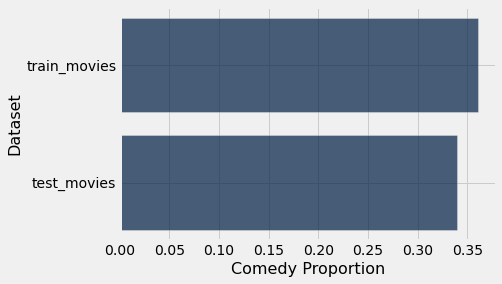

In [27]:
def comedy_proportion(table):
    # Return the proportion of movies in a table that have the comedy genre.
    return table.where('Genre', are.equal_to('comedy')).num_rows / table.num_rows

# The staff solution took multiple lines.  Start by creating a table.
# If you get stuck, think about what sort of table you need for barh to work
data = make_array('train_movies', 'test_movies')
tbl = Table().with_columns('Dataset', data, 'Comedy Proportion', make_array(comedy_proportion(train_movies), comedy_proportion(test_movies)))
tbl.barh('Dataset')

<!-- END QUESTION -->



# Part 2: K-Nearest Neighbors - A Guided Example

[K-Nearest Neighbors (k-NN)](https://inferentialthinking.com/chapters/17/1/Nearest_Neighbors.html) is a classification algorithm.  Given some numerical *attributes* (also called *features*) of an unseen example, it decides which category that example belongs to based on its similarity to previously seen examples. Predicting the category of an example is called *labeling*, and the predicted category is also called a *label*.

An attribute (feature) we have about each movie is *the proportion of times a particular word appears in the movie*, and the labels are two movie genres: comedy and thriller.  The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_movies` table.

To build understanding, we're going to visualize the algorithm instead of just describing it.

## 2.1. Classifying a movie

In k-NN, we classify a movie by finding the `k` movies in the *training set* that are most similar according to the features we choose. We call those movies with similar features the *nearest neighbors*.  The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each movie.  The features we will use are the proportions of the words "water" and "feel" in the movie.  Taking the movie *Monty Python and the Holy Grail* (in the test set), 0.000804074 of its words are "water" and 0.0010721 are "feel". This movie appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise.  We will say that the *distance* between two movies is the straight-line distance between them when we plot their features on a scatter diagram. 

**This distance is called the Euclidean ("yoo-KLID-ee-un") distance, whose formula is $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$.**

For example, in the movie *Clerks.* (in the training set), 0.00016293 of all the words in the movie are "water" and 0.00154786 are "feel".  Its distance from *Monty Python and the Holy Grail* on this 2-word feature set is $\sqrt{(0.000804074 - 0.000162933)^2 + (0.0010721 - 0.00154786)^2} \approx 0.000798379$.  (If we included more or different features, the distance could be different.)

A third movie, *The Godfather* (in the training set), has 0 "water" and 0.00015122 "feel". 

The function below creates a plot to display the "water" and "feel" features of a test movie and some training movies. As you can see in the result, *Monty Python and the Holy Grail* is more similar to *Clerks.* than to the *The Godfather* based on these features, which makes sense as both movies are comedy movies, while *The Godfather* is a thriller.

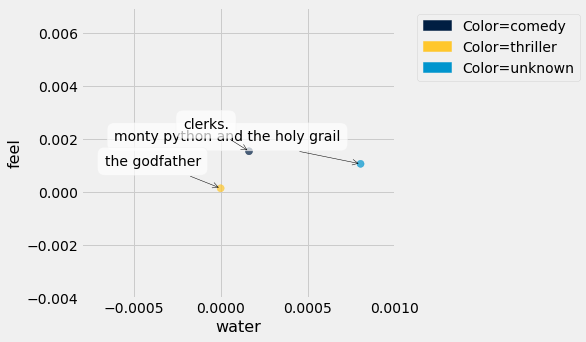

In [28]:
# Just run this cell.
def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
    """Plot a test movie and training movies using two features."""
    test_row = row_for_title(test_movie)
    distances = Table().with_columns(
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   ['unknown'],
            'Title',   [test_movie]
        )
    for movie in training_movies:
        row = row_for_title(movie)
        distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), movie])
    distances.scatter(x_feature, y_feature, group='Color', labels='Title', s=50)
    
training = ["clerks.", "the godfather"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel")
plots.axis([-0.0008, 0.001, -0.004, 0.007]);

#### Question 2.1.1

Compute the Euclidean distance (defined in the section above) between the two movies, *Monty Python and the Holy Grail* and *The Godfather*, using the `water` and `feel` features only.  Assign it the name `one_distance`. 

*Hint 1:* If you have a row, you can use `item` to get a value from a column by its name.  For example, if `r` is a row, then `r.item("Genre")` is the value in column `"Genre"` in row `r`.

*Hint 2:* Refer to the beginning of Part 1 if you don't remember what `row_for_title` does.

*Hint 3:* In the formula for Euclidean distance, think carefully about what `x` and `y` represent. Refer to the example in the text above if you are unsure.

<!--
BEGIN QUESTION
name: q2_1_1
points:
 - 0
 - 3
-->

In [29]:
python = row_for_title("monty python and the holy grail") 
godfather = row_for_title("the godfather") 

one_distance = np.sqrt((python.item('water') - godfather.item('water'))**2 + (python.item('feel') -  godfather.item('feel'))**2)
one_distance

0.0012225209151294461

In [30]:
grader.check("q2_1_1")

q2_1_1 results: All test cases passed!

Below, we've added a third training movie, *The Silence of the Lambs*. Before, the point closest to *Monty Python and the Holy Grail* was *Clerks.*, a comedy movie. However, now the closest point is *The Silence of the Lambs*, a thriller movie.

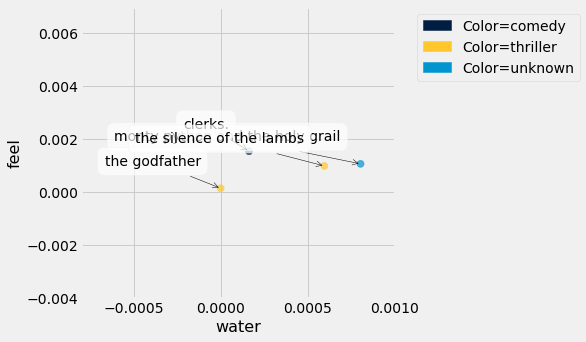

In [31]:
training = ["clerks.", "the godfather", "the silence of the lambs"] 
plot_with_two_features("monty python and the holy grail", training, "water", "feel") 
plots.axis([-0.0008, 0.001, -0.004, 0.007]);

#### Question 2.1.2
Complete the function `distance_two_features` that computes the Euclidean distance between any two movies, using two features. The last two lines call your function to show that *Monty Python and the Holy Grail* is closer to *The Silence of the Lambs* than it is to *Clerks*. 

<!--
BEGIN QUESTION
name: q2_1_2
points:
 - 1
 - 2
-->

In [32]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two movies with titles title0 and title1.
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    row0 = row_for_title(title0) 
    row1 = row_for_title(title1) 
    return np.sqrt((row0.item(x_feature) - row1.item(x_feature))**2 + (row0.item(y_feature) - row1.item(y_feature))**2)

for movie in make_array("clerks.", "the silence of the lambs"):
    movie_distance = distance_two_features(movie, "monty python and the holy grail", "water", "feel")
    print(movie, 'distance:\t', movie_distance)

clerks. distance:	 0.0007983810687227716
the silence of the lambs distance:	 0.00022256314855564847


In [33]:
grader.check("q2_1_2")

q2_1_2 results: All test cases passed!

#### Question 2.1.3
Define the function `distance_from_python` so that it works as described in its documentation. 

**Note:** Your solution should not use arithmetic operations directly. Instead, it should make use of existing functionality above!

<!--
BEGIN QUESTION
name: q2_1_3
points:
 - 0
 - 3
-->

In [34]:
def distance_from_python(title):
    """The distance between the given movie and "monty python and the holy grail", 
    based on the features "water" and "feel".
    
    This function takes a single argument:
      title: A string, the name of a movie.
    """
    
    return distance_two_features('monty python and the holy grail', title, 'water', 'feel')

# Calculate the distance between "Clerks." and "Monty Python and the Holy Grail"
distance_from_python('clerks.')

0.0007983810687227716

In [35]:
grader.check("q2_1_3")

q2_1_3 results: All test cases passed!

#### Question 2.1.4

Using the features `"water"` and `"feel"`, what are the names and genres of the 5 movies in the **training set** closest to *Monty Python and the Holy Grail*?  To answer this question, make a **table** named `close_movies` containing those 5 movies with columns `"Title"`, `"Genre"`, `"water"`, and `"feel"`, as well as a column called `"distance from python"` that contains the distance from *Monty Python and the Holy Grail*.  The table should be **sorted in ascending order by `"distance from python"`**.

*Note:* Why are smaller distances from *Monty Python and the Holy Grail* more helpful in helping us classify the movie?

*Hint:* Your final table should only have 5 rows. How can you get the first five rows of a table?


<!--
BEGIN QUESTION
name: q2_1_4
points:
 - 0
 - 0
 - 0
 - 3
-->

In [36]:
a = train_movies.column("Title")
distance = make_array()
# The staff solution took multiple lines.
for title in a:
    distance = np.append(distance, distance_from_python(title))
pdistance = train_movies.with_columns('distance from python', distance)
close_movies = pdistance.sort('distance from python').take(np.arange(5))
close_movies

Title                    | Year | Rating | Genre    | # Words | she         | decid       | talk        | wit         | razor | slam        | credit      | rai  | hugh | breez | conscienc | audienc | cathi | log         | met         | chosen | grip | booz        | bianca | doubl | agent       | exit | carpent | underground | clemenza | gain        | neg  | majesti     | studio | chri | spin        | greater     | eaten       | vibrat | stupid      | cigarett    | jesu        | mani        | violin | financi | bai         | cop  | neighbor | cd   | england | made        | conni | instinct    | took        | jacquelin | mace | disappear | waltz | behind      | bourbon     | favorit     | benni | manhattan   | nixon | lunch       | principl | tradit | counterfeit | sophi | third       | exist | wouldv      | hero | theyr       | anytim | christin | vallei | chess | paid        | burglar     | nostril | rubber      | human       | british    | plissken | eddi | gee         | offend      | rebecca | anger | plant | famou       | repres      | latest      | rent        | dip  | bell        | andi | so         | london     | cooler | keaton | portland | headlin | whatta | fatal | sew         | cheer | davi | feed        | hudson | ambros | digest | redi | fri  | staff | casino | occasion    | shadow | work        | restrain | face        | exercis     | sidnei     | pile | whyd        | teenag | her        | retir       | hazard | roth | hurrican    | impuls      | ranger | pour        | lester | slash | deer | could       | vital       | qualiti | coma        | incred | hank | famili      | duchess | global      | virgin | scientif    | between     | holidai     | qualifi     | moor | happili     | arizona | non  | bruce | ankl        | constant | buzz        | harder      | ing         | christian | palmer | tent | sunset      | damour | cohaagen | advertis    | sensat      | local | there      | terri | sedat | rotten | struck      | deck        | past        | bro  | ann  | dump        | kane | slot | immun | block       | lil  | technic | tactic | pencil      | outsid      | laboratori | easi        | nephew | coffin      | pretti      | coward      | verbal | permiss | bartend | wont        | watch       | lindenmey | cosmo | capabl      | flirt | huge        | berkelei | max         | walter | lime | rico | marvin | aboard | bacon | account     | kirk | quaid | stunt       | closet      | due         | nuclear     | blind | pussi | howdi | snuff | eas  | now        | leak        | underwear | westlei | mayb       | theo | limo | cousin      | illeg       | silli | against     | done        | district | invad | ryan | wait        | grudg | charact | hick | jami        | lifetim | lecktor | and        | republican | life        | hidden      | wire        | paranoia | network     | messi | uthatu | effort      | carri       | windham | fun         | psychologist | sean | scent | answer      | mom         | wake        | sign | ho   | relat | jame  | fat         | myself      | disrupt | scan       | vagu        | basket | christma | estim | em          | union | involv      | norman | suspici     | becom       | shoe        | librari     | administr | ford | complic     | stuck       | justic      | attack      | releas      | econom      | hesit | autopsi | jurisdict | four        | factor | inquiri     | lion | meanwhil | prison      | blair | seri | groceri | surgeri     | season | christi | clean       | ow          | wrestl | en   | moral | hungri      | cole        | surfer | sixteen | angl | shame       | barrel | major       | ago         | lott | airplan | worth       | train       | easili      | feller | valentin    | harvei | wherev      | francisco | true        | dramat | boston      | besid       | inspector | orlean | opportun    | nearli | lindsei | photograph  | frame | at         | psychopath  | press       | youyou | havana | australia | plai        | mayfield | chick | stewart | seven       | reflect | oute

In [37]:
grader.check("q2_1_4")

q2_1_4 results: All test cases passed!

#### Question 2.1.5
Next, we'll clasify *Monty Python and the Holy Grail* based on the genres of the closest movies. 

To do so, define the function `most_common` so that it works as described in its documentation below. 

<!--
BEGIN QUESTION
name: q2_1_5
points:
 - 3
-->

In [38]:
def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in the label column of the table.
    In case of a tie, it returns any one of the most common values.    
    """
    return table.group(label).sort('count', descending = True).column(0).item(0)

# Calling most_common on your table of 5 nearest neighbors classifies
# "monty python and the holy grail" as a thriller movie, 3 votes to 2. 
most_common('Genre', close_movies)

'thriller'

In [39]:
grader.check("q2_1_5")

q2_1_5 results: All test cases passed!

Congratulations are in order -- you've classified your first movie! However, we can see that the classifier doesn't work too well since it categorized *Monty Python and the Holy Grail* as a thriller movie (unless you count the thrilling holy hand grenade scene). Let's see if we can do better!

# Checkpoint (due Friday, 04/22 by 11:59pm PT)

<img src="opo1.jpeg" alt="drawing" width="300"/>
Opo wants to congratulate you on reaching the checkpoint! 



Run the cells that Opo is looking at and submit to the Gradescope assignment titled **Project 3 Checkpoint**.

<img src="opo.jpeg" alt="drawing" width="300"/>

**NOTE: This checkpoint does not represent the halfway point of the project. You are *highly* encouraged to continue on to the next section early.**

To get full credit for this checkpoint, you must pass all the public autograder tests above this cell. The cell below will rerun all of the autograder tests for Part 1 and Part 2 so that you can double check your work. 

In [40]:
checkpoint_tests = ["q1_0", "q1_1_1","q1_1_2","q1_1_3","q1_1_4","q1_2_1","q1_2_3",
                    "q2_1_1","q2_1_2","q2_1_3","q2_1_4","q2_1_5"]
for test in checkpoint_tests:
    display(grader.check(test))

q1_0 results: All test cases passed!

q1_1_1 results: All test cases passed!

q1_1_2 results: All test cases passed!

q1_1_3 results: All test cases passed!

q1_1_4 results: All test cases passed!

q1_2_1 results: All test cases passed!

q1_2_3 results: All test cases passed!

q2_1_1 results: All test cases passed!

q2_1_2 results: All test cases passed!

q2_1_3 results: All test cases passed!

q2_1_4 results: All test cases passed!

q2_1_5 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. You can do this by going to `Cell > Run All`. The cell below will generate a zip file for you to submit. **Please save before exporting!**

**Reminders:**
- Please remember to **add your partner to your Gradescope submission**. If you resubmit, make sure to re-add your partner, as Gradescope does not save any partner information.
- Make sure to wait until the autograder finishes running to ensure that your submission was processed properly and that you submitted to the correct assignment.

In [41]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, force_save=True)

<IPython.core.display.Javascript object>

# Part 3: Features

Now, we're going to extend our classifier to consider more than two features at a time.

Euclidean distance still makes sense with more than two features. For `n` different features, we compute the difference between corresponding feature values for two movies, square each of the `n`  differences, sum up the resulting numbers, and take the square root of the sum.

#### Question 3.0
Write a function called `distance` to compute the Euclidean distance between two **arrays** of **numerical** features (e.g. arrays of the proportions of times that different words appear). The function should be able to calculate the Euclidean distance between two arrays of arbitrary (but equal) length.

Next, use the function you just defined to compute the distance **between the first and second movie** in the **training set** *using all of the features*.  (Remember that the first five columns of your tables are not features.)

*Hint 1:* To convert rows to arrays, use `np.array`. For example, if `t` was a table, `np.array(t.row(0))` converts row 0 of `t` into an array.

*Hint 2:* Make sure to drop the first five columns of the table before you compute `distance_first_to_second`, as these columns do not contain any features (the proportions of words). 

<!--
BEGIN QUESTION
name: q3_0
points:
 - 0
 - 0
 - 0
 - 0.75
 - 0.75
 - 0.75
 - 0.75
-->

In [42]:
def distance(features_array1, features_array2):
    """The Euclidean distance between two arrays of feature values."""
    return np.sqrt(np.sum((features_array1 - features_array2)**2))

distance_first_to_second = distance(np.array(train_movies.drop((np.arange(5))).row(0)), np.array(train_movies.drop((np.arange(5))).row(1)))
distance_first_to_second
np.array(train_movies.drop((np.arange(5))).row(0))

array([0.0061667 , 0.00059678, 0.00159141, ..., 0.        , 0.        ,
       0.        ])

In [43]:
grader.check("q3_0")

q3_0 results: All test cases passed!

## 3.1. Creating your own feature set

Unfortunately, using all of the features has some downsides.  One clear downside is the lack of *computational efficiency* -- computing Euclidean distances just takes a long time when we have lots of features.  You might have noticed that in the last question!

So we're going to select just 20.  We'd like to choose features that are very *discriminative*. That is, features which lead us to correctly classify as much of the test set as possible.  This process of choosing features that will make a classifier work well is sometimes called *feature selection*, or, more broadly, *feature engineering*.

In this question, we will help you get started on selecting more effective features for distinguishing comedy from thriller movies. The plot below (generated for you) shows the average number of times each word occurs in a comedy movie on the horizontal axis and the average number of times it occurs in an thriller movie on the vertical axis. 


*Note: The line graphed is the line of best fit, NOT the line y=x.*

![alt text](word_plot.png "Title")

Questions 3.1.1 through 3.1.4 will ask you to interpret the plot above. For each question, select one of the following choices and assign its number to the provided name.
1. The word is common in both comedy and thriller movies 
2. The word is uncommon in comedy movies and common in thriller movies
3. The word is common in comedy movies and uncommon in thriller movies
4. The word is uncommon in both comedy and thriller movies
5. It is not possible to say from the plot 
    
**Question 3.1.1**

What properties do words in the bottom left corner of the plot have? Your answer should be a single integer from 1 to 5, corresponding to the correct statement from the choices above.

<!--
BEGIN QUESTION
name: q3_1_1
points:
 - 0
 - 3
-->

In [44]:
bottom_left = 4

In [45]:
grader.check("q3_1_1")

q3_1_1 results: All test cases passed!

**Question 3.1.2**

What properties do words in the bottom right corner have?

<!--
BEGIN QUESTION
name: q3_1_2
points:
 - 0
 - 3
-->

In [46]:
bottom_right = 3

In [47]:
grader.check("q3_1_2")

q3_1_2 results: All test cases passed!

**Question 3.1.3**

What properties do words in the top right corner have? 

<!--
BEGIN QUESTION
name: q3_1_3
points:
 - 0
 - 3
-->

In [48]:
top_right = 1

In [49]:
grader.check("q3_1_3")

q3_1_3 results: All test cases passed!

**Question 3.1.4**

What properties do words in the top left corner have?

<!--
BEGIN QUESTION
name: q3_1_4
points:
 - 0
 - 3
-->

In [50]:
top_left = 2

In [51]:
grader.check("q3_1_4")

q3_1_4 results: All test cases passed!

**Question 3.1.5**

If we see a movie with a lot of words that are common for comedy movies but uncommon for thriller movies, what would be a reasonable guess about the genre of the movie? Assign `movie_genre` to the integer corresponding to your answer:
1. It is a thriller movie.
2. It is a comedy movie.

<!--
BEGIN QUESTION
name: q3_1_5
points:
 - 0
 - 3
-->

In [52]:
movie_genre_guess = 2

In [53]:
grader.check("q3_1_5")

q3_1_5 results: All test cases passed!

#### Question 3.1.6
Using the plot above, make an array of at least 10 common words that you think might let you **distinguish** between comedy and thriller movies. Make sure to choose words that are **frequent enough** that every movie contains at least one of them. Don't just choose the most frequent words though--you can do much better.

<!--
BEGIN QUESTION
name: q3_1_6
points:
 - 0
 - 0
 - 0
 - 1.5
 - 1.5
 
-->

In [54]:
# Set my_features to an array of at least 10 features (strings that are column labels)

my_features = make_array('oh', 'realli', 'yeah', 'well', 'my', 'marri', 'walter', 'uh', 'great', 'love')

# Select the 10 features of interest from both the train and test sets
train_my_features = train_movies.select(my_features)
test_my_features = test_movies.select(my_features)

In [55]:
grader.check("q3_1_6")

q3_1_6 results: All test cases passed!

This test makes sure that you have chosen words such that at least one appears in each movie. If you can't find words that satisfy this test just through intuition, try writing code to print out the titles of movies that do not contain any words from your list, then look at the words they do contain.

<!-- BEGIN QUESTION -->

#### Question 3.1.7
In two sentences or less, describe how you selected your features.

<!--
BEGIN QUESTION
name: q3_1_7
manual: True
-->

I looked at the graph and chose features that were below the dotted red line.

<!-- END QUESTION -->



Next, let's classify the first movie from our test set using these features.  You can examine the movie by running the cells below. Do you think it will be classified correctly?

In [56]:
print("Movie:")
test_movies.take(0).select('Title', 'Genre').show()
print("Features:")
test_my_features.take(0).show()

Movie:


Title,Genre
ghostbusters ii,comedy


Features:


oh,realli,yeah,well,my,marri,walter,uh,great,love
0.00313221,0.00263765,0.00214309,0.00362677,0.0074184,0.000164853,0,0.000164853,0.000659413,0.000824266


As before, we want to look for the movies in the training set that are most like our test movie.  We will calculate the Euclidean distances from the test movie (using `my_features`) to all movies in the training set.  You could do this with a `for` loop, but to make it computationally faster, we have provided a function, `fast_distances`, to do this for you.  Read its documentation to make sure you understand what it does.  (You don't need to understand the code in its body unless you want to.)

In [57]:
# Just run this cell to define fast_distances.

def fast_distances(test_row, train_table):
    """Return an array of the distances between test_row and each row in train_table.
    
    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test movie (e.g., test_my_features.row(0)).
      train_table: A table of features (for example, the whole
        table train_my_features)."""
    assert train_table.num_columns < 50, "Make sure you're not using all the features of the movies table."
    assert type(test_row) != datascience.tables.Table, "Make sure you are passing in a row object to fast_distances."
    assert len(test_row) == len(train_table.row(0)), "Make sure the length of test row is the same as the length of a row in train_table."
    counts_matrix = np.asmatrix(train_table.columns).transpose()
    diff = np.tile(np.array(list(test_row)), [counts_matrix.shape[0], 1]) - counts_matrix
    np.random.seed(0) # For tie breaking purposes
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(1))))
    eps = np.random.uniform(size=distances.shape)*1e-10 #Noise for tie break
    distances = distances + eps
    return distances

#### Question 3.1.8
Use the `fast_distances` function provided above to compute the distance from the first movie in your test set to all the movies in your training set, **using your set of features**. Make a new table called `genre_and_distances` with one row for each movie in the training set and two columns:
* The `"Genre"` of the training movie
* The `"Distance"` from the first movie in the test set 

Ensure that `genre_and_distances` is **sorted in ascending order by distance to the first test movie**.

*Hint:* Think about how you can use the variables you defined in 3.1.6.

<!--
BEGIN QUESTION
name: q3_1_8
points:
 - 0
 - 1
 - 1
 - 1
-->

In [58]:
# The staff solution took multiple lines of code.
genre_and_distances = fast_distances(test_my_features.row(0), train_my_features.select(my_features))
genre_and_distances = train_movies.select('Genre').with_columns('Distance', genre_and_distances).sort('Distance')
genre_and_distances

Genre,Distance
comedy,0.00152715
thriller,0.00206581
thriller,0.00209217
thriller,0.00215196
comedy,0.00216268
comedy,0.0021858
comedy,0.00223866
thriller,0.00227019
thriller,0.00229243
thriller,0.00240744


In [59]:
grader.check("q3_1_8")

q3_1_8 results: All test cases passed!

#### Question 3.1.9
Now compute the 7-nearest neighbors classification of the first movie in the test set.  That is, decide on its genre by finding the most common genre among its 7 nearest neighbors in the training set, according to the distances you've calculated.  Then check whether your classifier chose the right genre.  (Depending on the features you chose, your classifier might not get this movie right, and that's okay.)

*Hint:* You should use the `most_common` function that was defined earlier.

<!--
BEGIN QUESTION
name: q3_1_9
points:
 - 1
 - 1
-->

In [128]:
# Set my_assigned_genre to the most common genre among these.
my_assigned_genre = most_common('Genre', genre_and_distances.take(np.arange(7)))

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first movie in the test set, False otherwise.
my_assigned_genre_was_correct = True

print("The assigned genre, {}, was{}correct.".format(my_assigned_genre, " " if my_assigned_genre_was_correct else " not "))

The assigned genre, comedy, was correct.


In [129]:
grader.check("q3_1_9")

q3_1_9 results: All test cases passed!

## 3.2. A classifier function

Now we can write a single function that encapsulates the whole process of classification.

#### Question 3.2.1
Write a function called `classify`.  It should take the following four arguments:
* A row of features for a movie to classify (e.g., `test_my_features.row(0)`).
* A table with a column for each feature (e.g., `train_my_features`).
* An array of classes (e.g. the labels "comedy" or "thriller") that has as many items as the previous table has rows, and in the same order. *Hint:* What are the labels of each row in the training set? 
* `k`, the number of neighbors to use in classification.

It should return the class a `k`-nearest neighbor classifier picks for the given row of features (the string `'comedy'` or the string `'thriller'`). 

<!--
BEGIN QUESTION
name: q3_2_1
points:
 - 1.5
 - 1.5
-->

In [62]:
def classify(test_row, train_features, train_labels, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = fast_distances(test_row, train_features)
    genre_and_distances = Table().with_columns('Genre', train_labels, 'Distance', distances).sort('Distance')
    neighbors = genre_and_distances.take(np.arange(k))
    comedy = neighbors.where('Genre', 'comedy').num_rows
    thriller = neighbors.where('Genre', 'thriller').num_rows
    if comedy > thriller:
        return 'comedy'
    else:
        return 'thriller'

In [63]:
grader.check("q3_2_1")

q3_2_1 results: All test cases passed!

#### Question 3.2.2

Assign `godzilla_genre` to the genre predicted by your classifier for the movie "godzilla" in the test set, using **15 neighbors** and using your 10 features. 

*Hint:* The `row_for_title` function will not work here.

<!--
BEGIN QUESTION
name: q3_2_2
points:
 - 3
-->

In [64]:
# The staff solution first defined a row called godzilla_features.
godzilla_features = test_movies.where('Title', 'godzilla').select(my_features).row(0)
godzilla_genre = classify(godzilla_features, train_my_features, train_movies.column('Genre'), 15)
godzilla_genre

'thriller'

In [65]:
grader.check("q3_2_2")

q3_2_2 results: All test cases passed!

Finally, when we evaluate our classifier, it will be useful to have a classification function that is specialized to use a fixed training set and a fixed value of `k`.

#### Question 3.2.3
Create a classification function that takes as its argument a row containing your 10 features and classifies that row using the 15-nearest neighbors algorithm with `train_my_features` as its training set. 

<!--
BEGIN QUESTION
name: q3_2_3
points:
 - 3
-->

In [66]:
def classify_feature_row(row):
    return classify(row, train_my_features, train_movies.column('Genre'), 15)

# When you're done, this should produce 'thriller' or 'comedy'.
classify_feature_row(test_my_features.row(0))

'thriller'

In [67]:
grader.check("q3_2_3")

q3_2_3 results: All test cases passed!

## 3.3. Evaluating your classifier

Now that it's easy to use the classifier, let's see how accurate it is on the whole test set.

**Question 3.3.1**

Use `classify_feature_row` and `apply` to classify every movie in the test set.  Assign these guesses as an array to `test_guesses`.  Then, compute the proportion of correct classifications.

*Hint 1*: If you do not specify any columns in `tbl.apply(...)`, your function will be applied to every row object in `tbl`.

*Hint 2*: Which dataset do you want to apply this function to?

<!--
BEGIN QUESTION
name: q3_3_1
points:
 - 0
 - 3
-->

In [86]:
test_guesses = test_my_features.apply(classify_feature_row)
proportion_correct = np.count_nonzero(test_guesses == test_movies.column('Genre'))/len(test_guesses)
proportion_correct

0.68

In [70]:
grader.check("q3_3_1")

q3_3_1 results: All test cases passed!

**Question 3.3.2** 

An important part of evaluating your classifiers is figuring out where they make mistakes. Assign the name `test_movie_correctness` to a table with three columns, `'Title'`, `'Genre'`, and `'Was correct'`. 

- The `'Genre'` column should contain the original genres, not the ones you predicted. 
- The `'Was correct'` column should contain `True` or `False` depending on whether or not the movie was classified correctly.

<!--
BEGIN QUESTION
name: q3_3_2
points:
 - 0
 - 0
 - 3
-->

In [82]:
# Feel free to use multiple lines of code
# but make sure to assign test_movie_correctness to the proper table!
test_movie_correctness = test_movies.select('Title', 'Genre').with_columns('Was correct', test_guesses == test_movies.column('Genre'))
test_movie_correctness.sort('Was correct', descending = True).show(5)

Title,Genre,Was correct
intolerable cruelty,comedy,True
psycho,thriller,True
book of shadows: blair witch 2,thriller,True
the getaway,thriller,True
mission: impossible,thriller,True


In [73]:
grader.check("q3_3_2")

q3_3_2 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 3.3.3** 

Do you see a pattern in the types of movies your classifier misclassifies? In two sentences or less, describe any patterns you see in the results or any other interesting findings from the table above. If you need some help, try looking up the movies that your classifier got wrong on Wikipedia. 

<!--
BEGIN QUESTION
name: q3_3_3
manual: true
-->

I think it is really interesting to note how movies are not completely tied to their genre. For example, the ghostbusters has some "thriller" elements given its spooky elements. There is definitely a lot of movies like those where thriller and comedy intersect.

<!-- END QUESTION -->



At this point, you've gone through one cycle of classifier design.  Let's summarize the steps:
1. From available data, select test and training sets.
2. Choose an algorithm you're going to use for k-NN classification.
3. Identify some features.
4. Define a classifier function using your features and the training set.
5. Evaluate its performance (the proportion of correct classifications) on the test set.

# Part 4: Explorations
Now that you know how to evaluate a classifier, it's time to build another one.

Your friends are big fans of comedy and thriller movies. They have created their own dataset of movies that they want to watch, but they need your help in determining the genre of each movie in their dataset (comedy or thriller). You have never seen any of the movies in your friends' dataset, so none of your friends' movies are present in your training or test set from earlier. In other words, this new dataset of movies can function as another test set that we are going to make predictions on based on our original training data. 

Run the following cell to load your friends' movie data.

In [ ]:
friend_movies = Table.read_table('friend_movies.csv')
friend_movies.show(5)

**Question 4.1** 

Your friend's computer is not as powerful as yours, so they tell you that the classifier you create for them can only have up to 5 words as features. Develop a new classifier with the constraint of **using no more than 5 features.** Assign `new_features` to an array of your features.

Your new function should have the same arguments as `classify_feature_row` and return a classification. Name it `another_classifier`. Then, output your accuracy using code from earlier to compare the new classifier to your old one. 

Some ways you can change your classifier are by using different features or trying different values of `k`. (Of course, you still have to use `train_movies` as your training set!)

**Make sure you don't reassign any previously used variables here**, such as `proportion_correct` from the previous question.

*Note:* There's no one right way to do this! Just make sure that you can explain your reasoning behind the new choices.

<!--
BEGIN QUESTION
name: q4_1
points:
 - 0
 - 3
-->

In [118]:
new_features = make_array('walter', 'laugh', 'fun', 'sweet')

train_new = train_movies.select(new_features)
test_new = test_movies.select(new_features)

def another_classifier(row):
    return classify(row, train_new, train_movies.column('Genre'), 20)

new_guesses = test_new.apply(another_classifier)
new_proportion = np.count_nonzero(new_guesses == test_movies.column('Genre'))/len(new_guesses)
new_proportion

0.74

In [119]:
grader.check("q4_1")

q4_1 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 4.2** 

Do you see a pattern in the mistakes your new classifier makes? How good an accuracy were you able to get with your limited classifier? Did you notice an improvement from your first classifier to the second one? Describe in two sentences or less. 

*Hint:* You may not be able to see a pattern.

<!--
BEGIN QUESTION
name: q4_2
manual: true
-->

There was a slight improvement of about 5% in our new classifier. I do understand that there is definitely a lot of overlap between the latter three movies in the new features. Walter had virtually no association with horror movies.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 4.3** 

Given the constraint of five words, how did you select those five? Describe in two sentences or less.

<!--
BEGIN QUESTION
name: q4_3
manual: true
-->

The first feature ('walter') I pulled from the occurence graph given its extremely low association with thriller movies (for some reason). The other three were just words I came up with on what I associated with comedy movies and were in the table.

<!-- END QUESTION -->



# Part 5: Other Classification Methods (OPTIONAL)

**Note**: Everything below is **OPTIONAL**. Please only work on this part after you have finished and submitted the project. If you create new cells below, do NOT reassign variables defined in previous parts of the project.

Now that you've finished your k-NN classifier, you might be wondering what else you could do to improve your accuracy on the test set. Classification is one of many machine learning tasks, and there are plenty of other classification algorithms! If you feel so inclined, we encourage you to try any methods you feel might help improve your classifier. 

We've compiled a list of blog posts with some more information about classification and machine learning. Create as many cells as you'd like below--you can use them to import new modules or implement new algorithms. 

Blog posts: 

* [Classification algorithms/methods](https://medium.com/@sifium/machine-learning-types-of-classification-9497bd4f2e14)
* [Train/test split and cross-validation](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)
* [More information about k-nearest neighbors](https://medium.com/@adi.bronshtein/a-quick-introduction-to-k-nearest-neighbors-algorithm-62214cea29c7)
* [Overfitting](https://elitedatascience.com/overfitting-in-machine-learning)

In future data science classes, such as Data Science 100, you'll learn about some of the algorithms in the blog posts above, including logistic regression. You'll also learn more about overfitting, cross-validation, and approaches to different kinds of machine learning problems.

One module that you can consider using is [Scikit-learn](http://scikit-learn.org/stable/tutorial/basic/tutorial.html). There's a lot to think about, so we encourage you to find more information on your own!

In [111]:
...

# Yoshi wants to say: Congratulations! You have finished Project 3.

<img src="yoshi.jpeg" alt="drawing" width="300"/>

Using your statistics and machine learning skills you have:
- Investigated a movie script dataset
- Identified word associations
- Built a machine learning model to classify movies by their scripts

Please make sure you have added your partner on Gradescope. If you have done it, set `add_partner` to True.

<!--
BEGIN QUESTION
name: q5_1
manual: false
points:
- 2
-->

In [120]:
add_partner = True

In [121]:
grader.check("q5_1")

q5_1 results: All test cases passed!

You're finished! Time to submit. 


**Reminders:**
- Please remember to **add your partner to your Gradescope submission**. If you resubmit, make sure to re-add your partner, as Gradescope does not save any partner information. 
- Please note that filling out the Official Project 3 Partner form is NOT the same as adding your partner to your Gradescope submission. **In order to get credit for the project, you must do both of the following: add your partner to your Gradescope submission AND fill out the partner form.**
- Make sure to wait until the autograder finishes running to ensure that your submission was processed properly and that you submitted to the correct assignment.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [130]:
grader.check_all()

q1_0 results: All test cases passed!

q1_1_1 results: All test cases passed!

q1_1_2 results: All test cases passed!

q1_1_3 results: All test cases passed!

q1_1_4 results: All test cases passed!

q1_2_1 results: All test cases passed!

q1_2_3 results: All test cases passed!

q2_1_1 results: All test cases passed!

q2_1_2 results: All test cases passed!

q2_1_3 results: All test cases passed!

q2_1_4 results: All test cases passed!

q2_1_5 results: All test cases passed!

q3_0 results: All test cases passed!

q3_1_1 results: All test cases passed!

q3_1_2 results: All test cases passed!

q3_1_3 results: All test cases passed!

q3_1_4 results: All test cases passed!

q3_1_5 results: All test cases passed!

q3_1_6 results: All test cases passed!

q3_1_8 results: All test cases passed!

q3_1_9 results: All test cases passed!

q3_2_1 results: All test cases passed!

q3_2_2 results: All test cases passed!

q3_2_3 results: All test cases passed!

q3_3_1 results: All test cases passed!

q3_3

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [131]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)